<a href="https://colab.research.google.com/github/niteshg97/Assignment-for-AIRL-Intern-Position/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [ ]:
batch_size = 128
img_size = 32
patch_size = 4
num_channels = 3
num_patches = (img_size // patch_size) ** 2

num_heads = 4
embed_dim = 192
mlp_dim = 384
transformer_units = 6
num_classes = 10

learning_rate = 3e-4
weight_decay = 0.05
num_epochs = 50

In [ ]:
#  Using Data Augmentation To Improve Accuracy (NOTE:without data augmentation i was able to achieve only 53% Validation Accuracy)

# For training, we apply aggressive augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    # Normalize with CIFAR-10 specific values
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# For validation, we only normalize
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

In [ ]:
#Python image library (PIL) to tensor
transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=val_transform)

In [ ]:
#using dataloader  to prepare for the Neural Network
train_data = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
#Class for Patch Embedding (Part 1 of ViT Architecture)
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

In [ ]:
#Class for Transformer Encoder (Part 2 of the ViT Architecture)

class TransformerArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.multi_layer_perceptron = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        residual_1 = x
        x_norm1 = self.layer_norm_1(x)
        attention_output, _ = self.self_attention(x_norm1, x_norm1, x_norm1)
        x = attention_output + residual_1

        residual_2 = x
        x_norm2 = self.layer_norm_2(x)
        mlp_output = self.multi_layer_perceptron(x_norm2)
        x = mlp_output + residual_2
        return x


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()

        # learnable CLS token for classification
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # Stacking the Transformer encoder blocks
        self.transformer_layers = nn.Sequential(*[TransformerArchitecture() for _ in range(transformer_units)])

        # Final MLP head for classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        B = x.size(0)

        # Prepending the CLS token to the patch embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Adding positional embeddings
        x = x + self.pos_embed

        x = self.transformer_layers(x)

        # Taking the output of the CLS token for classification
        x = x[:, 0]

        x = self.mlp_head(x)
        return x

In [ ]:
#  TRAINING SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = VisionTransformer().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

Using device: cuda


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0

    for batch_idx, (images, labels) in enumerate(train_data, 1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_epoch += (preds == labels).sum().item()
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f'  Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(train_data)} | Loss: {loss.item():.4f}')

    scheduler.step()

    epoch_acc = 100.0 * correct_epoch / total_epoch
    epoch_loss = total_loss / len(train_data)
    print(f"==> Epoch {epoch+1} Summary: Avg Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images_val, labels_val in val_data:
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            outputs_val = model(images_val)
            preds_val = outputs_val.argmax(dim=1)
            correct_val += (preds_val == labels_val).sum().item()
            total_val += labels_val.size(0)
    val_acc = 100.0 * correct_val / total_val
    print(f"==> Validation Accuracy: {val_acc:.2f}%")

print("\nTraining finished!")

  Epoch 1/50 | Batch 100/391 | Loss: 1.9679
  Epoch 1/50 | Batch 200/391 | Loss: 2.0696
  Epoch 1/50 | Batch 300/391 | Loss: 1.7172
==> Epoch 1 Summary: Avg Loss = 1.9451, Accuracy = 28.70%
==> Validation Accuracy: 46.37%
  Epoch 2/50 | Batch 100/391 | Loss: 1.6496
  Epoch 2/50 | Batch 200/391 | Loss: 1.6787
  Epoch 2/50 | Batch 300/391 | Loss: 1.6439
==> Epoch 2 Summary: Avg Loss = 1.6971, Accuracy = 38.89%
==> Validation Accuracy: 51.38%
  Epoch 3/50 | Batch 100/391 | Loss: 1.7354
  Epoch 3/50 | Batch 200/391 | Loss: 1.7449
  Epoch 3/50 | Batch 300/391 | Loss: 1.5207
==> Epoch 3 Summary: Avg Loss = 1.6003, Accuracy = 42.73%
==> Validation Accuracy: 53.72%
  Epoch 4/50 | Batch 100/391 | Loss: 1.5535
  Epoch 4/50 | Batch 200/391 | Loss: 1.6885
  Epoch 4/50 | Batch 300/391 | Loss: 1.5825
==> Epoch 4 Summary: Avg Loss = 1.5346, Accuracy = 44.95%
==> Validation Accuracy: 56.30%
  Epoch 5/50 | Batch 100/391 | Loss: 1.4342
  Epoch 5/50 | Batch 200/391 | Loss: 1.6438
  Epoch 5/50 | Batch 300

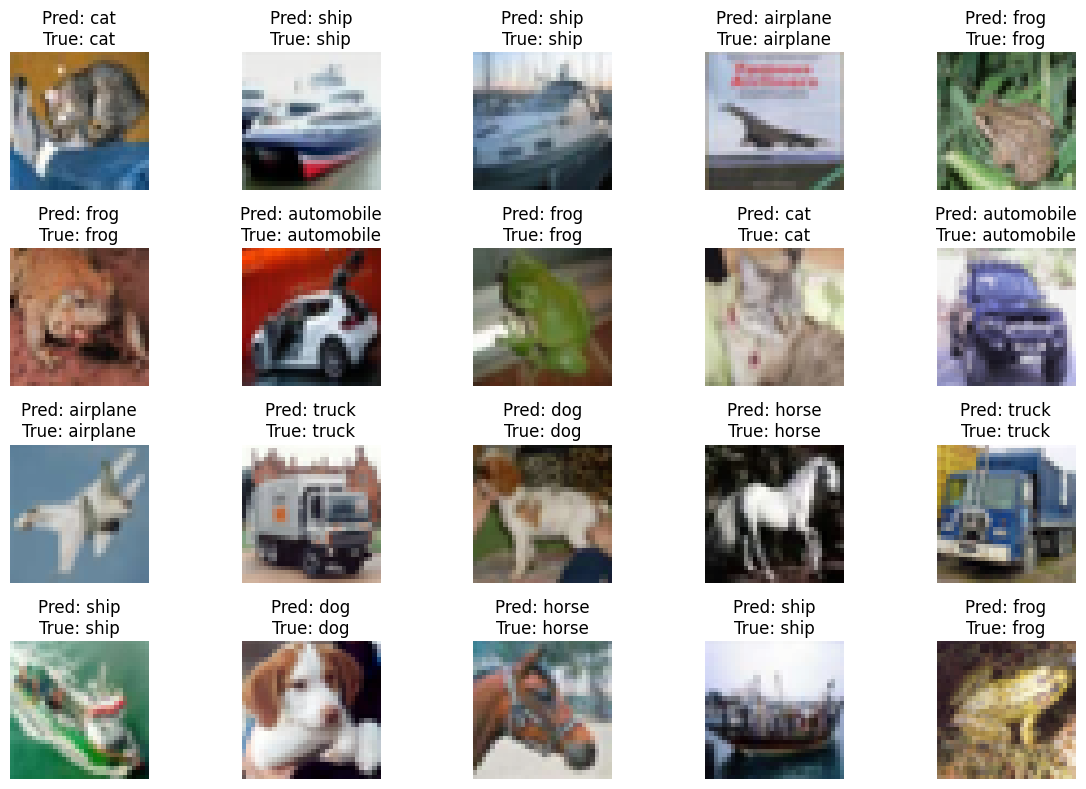

In [ ]:
#  VISUALIZATION
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)
class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    img_display = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)
    plt.imshow(img_display)
    plt.title(f"Pred: {class_names[preds[i].item()]}\nTrue: {class_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()